# **A Bayesian Approach To University Venue Allocation** 
## Honours Research Prpject
#### Mmasehume Raphiri (2089198@students.wits.ac.za)

# Install Packages
---
only have to do this when running notebook for the first time

In [90]:
# # Install pgmpy
# %pip install pgmpy
# # Install daft
# %pip install -U daft
# # # Install libgraphviz
# !sudo apt install libgraphviz-dev
# # # Install pygraphviz
# %pip install pygraphviz

# Import Libraries

In [91]:
import random
import seaborn
import numpy as np
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from random import sample
from IPython import display
import tqdm as notebook_tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import Image
from pgmpy.models import BayesianModel
from pgmpy.sampling import GibbsSampling
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import structure_score
from pgmpy.estimators import HillClimbSearch
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score, BicScore
from pgmpy.metrics import log_likelihood_score
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import MaximumLikelihoodEstimator

# Mount drive

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline Bayesian Model
---
> *Hard Constraints*
- students can only attend one class at a time
- a venue can have only one class at a time 
- for every class, each venue must have the necesseray equipment
- for each class, the venue must have enough seats 

> *Soft Constraints*
- the number of empty seats should be minimized
- the distance between 2 venues should be minimized


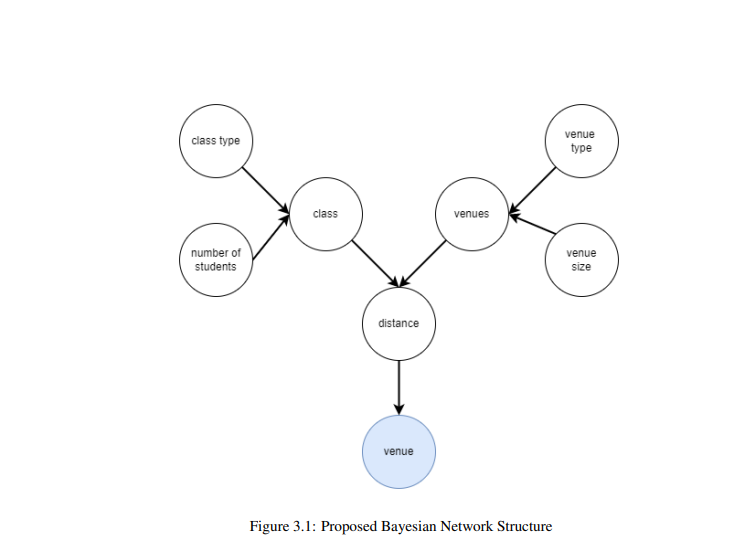

Class ranges, if :
- Number of students:
>>>- between 18 and 45 : 0
>>>- greater than 45 : 1
- Class Type : 
>>>- Tutorial : 0
>>>- Lab : 1
>>>- Lecture : 2
- Venue size:
>>>- 45 seats or less seats: 0
>>>- greater than 45 seats: 1
- Venue Type:
>>>- Tutorial : 0
>>>- Lab : 1
>>>- Lecture : 2
- Distance:
>>>- Less than 50m from faculty office : 0
>>>- Between 50m and 100m from faculty office : 1
>>>- Far from faculty office : 2
- Venue:
>>>- Tutorial : 0
>>>- Lab : 1
>>>- Lecture : 2


In [93]:
# define model structure
digraph = (("Num_students", "Class"),
        ("Class_Type", "Class"),
        ("Class","Distance"),
        ("Venue_Size", "Venues"),
        ("Venue_Type", "Venues"),
        ("Venues", "Distance"),
        ("Distance", "Venue"))
baseline_model = BayesianNetwork(digraph)

## Define Conditional Probabilities

### Random Conditional Probability Values
- computes random cpd values for each variable that add up to 1

In [94]:
def cpd_values(variable_card, evidence_card = [1]):
  n = np.prod(evidence_card)
  M = np.random.rand(variable_card, n)
  r = M.sum(axis=0)
  values = np.around(M / r, 4)
  return values.tolist()

### Root Nodes

#### Class Type

In [95]:
cpd_class_type = TabularCPD(variable="Class_Type", variable_card=3, values=cpd_values(variable_card=3))
# values=[[0.6], [0.2], [0.2]]
baseline_model.add_cpds(cpd_class_type)
print(cpd_class_type)

+---------------+--------+
| Class_Type(0) | 0.0792 |
+---------------+--------+
| Class_Type(1) | 0.2684 |
+---------------+--------+
| Class_Type(2) | 0.6524 |
+---------------+--------+


#### Number of Students

In [96]:
cpd_num_students = TabularCPD(variable="Num_students", variable_card=2, values=cpd_values(variable_card=2))
# values=[[0.2], [0.8]]
baseline_model.add_cpds(cpd_num_students)
print(cpd_num_students)

+-----------------+--------+
| Num_students(0) | 0.7113 |
+-----------------+--------+
| Num_students(1) | 0.2887 |
+-----------------+--------+


#### Venue Type

In [97]:
cpd_venue_type = TabularCPD( variable="Venue_Type", variable_card=3, values=cpd_values(variable_card=3))
# values=[[0.65], [0.20], [0.15]]
baseline_model.add_cpds(cpd_venue_type)
print(cpd_venue_type)

+---------------+--------+
| Venue_Type(0) | 0.3166 |
+---------------+--------+
| Venue_Type(1) | 0.087  |
+---------------+--------+
| Venue_Type(2) | 0.5964 |
+---------------+--------+


#### Venue Size

In [98]:
cpd_venue_size = TabularCPD( variable="Venue_Size", variable_card=2, values=cpd_values(variable_card=2))
# values=[[0.2], [0.8]]
baseline_model.add_cpds(cpd_venue_size)
print(cpd_venue_size)

+---------------+--------+
| Venue_Size(0) | 0.5576 |
+---------------+--------+
| Venue_Size(1) | 0.4424 |
+---------------+--------+


### Internal Nodes

#### Class

In [99]:
cpd_class = TabularCPD( variable="Class",
                       variable_card=3,
                       values=cpd_values(variable_card=3, evidence_card=[2, 3]),
                       evidence=["Num_students", "Class_Type"],
                       evidence_card=[2, 3])
# values=[[0.03, 0.05, 0.92, 0.72, 0.39, 0.08], [0.79, 0.55, 0.02, 0.03, 0.01, 0.77], [0.18, 0.4, 0.06, 0.25, 0.6, 0.15]], 
baseline_model.add_cpds(cpd_class)
print(cpd_class)

+--------------+-----------------+-----+-----------------+
| Num_students | Num_students(0) | ... | Num_students(1) |
+--------------+-----------------+-----+-----------------+
| Class_Type   | Class_Type(0)   | ... | Class_Type(2)   |
+--------------+-----------------+-----+-----------------+
| Class(0)     | 0.1679          | ... | 0.7902          |
+--------------+-----------------+-----+-----------------+
| Class(1)     | 0.0113          | ... | 0.1561          |
+--------------+-----------------+-----+-----------------+
| Class(2)     | 0.8208          | ... | 0.0537          |
+--------------+-----------------+-----+-----------------+


#### Venues
- possible vebues to choose from

In [100]:
cpd_venues = TabularCPD( 
    variable="Venues",
    variable_card= 3,
    values=cpd_values(variable_card=3, evidence_card=[3, 2]),
    evidence=["Venue_Type", "Venue_Size"],
    evidence_card=[3, 2],
)
#values=[[0.65, 0.35, 0.23, 0.22, 0.14, 0.32], [0.25, 0.45, 0.32, 0.63, 0.001, 0.18], [0.1, 0.2, 0.45, 0.15, 0.859, 0.5]],
baseline_model.add_cpds(cpd_venues)
print(cpd_venues)

+------------+---------------+-----+---------------+---------------+
| Venue_Type | Venue_Type(0) | ... | Venue_Type(2) | Venue_Type(2) |
+------------+---------------+-----+---------------+---------------+
| Venue_Size | Venue_Size(0) | ... | Venue_Size(0) | Venue_Size(1) |
+------------+---------------+-----+---------------+---------------+
| Venues(0)  | 0.53          | ... | 0.346         | 0.5094        |
+------------+---------------+-----+---------------+---------------+
| Venues(1)  | 0.243         | ... | 0.3214        | 0.208         |
+------------+---------------+-----+---------------+---------------+
| Venues(2)  | 0.227         | ... | 0.3326        | 0.2826        |
+------------+---------------+-----+---------------+---------------+


#### Distance

In [101]:
cpd_distance = TabularCPD( variable="Distance", variable_card=3,
                          values=cpd_values(variable_card=3, evidence_card=[3, 3]),
                          evidence=["Class","Venues"],
                          evidence_card=[3, 3])
# values=[[0.03, 0.05, 0.92, 0.72, 0.39, 0.08, 0.03, 0.05, 0.92], [0.79, 0.55, 0.02, 0.03, 0.01, 0.77, 0.79, 0.55, 0.02], [0.18, 0.4, 0.06, 0.25, 0.6, 0.15, 0.18, 0.4, 0.06]], 
baseline_model.add_cpds(cpd_distance)
print(cpd_distance)

+-------------+-----------+-----+-----------+-----------+
| Class       | Class(0)  | ... | Class(2)  | Class(2)  |
+-------------+-----------+-----+-----------+-----------+
| Venues      | Venues(0) | ... | Venues(1) | Venues(2) |
+-------------+-----------+-----+-----------+-----------+
| Distance(0) | 0.5222    | ... | 0.3069    | 0.2281    |
+-------------+-----------+-----+-----------+-----------+
| Distance(1) | 0.2298    | ... | 0.5972    | 0.5765    |
+-------------+-----------+-----+-----------+-----------+
| Distance(2) | 0.248     | ... | 0.0959    | 0.1954    |
+-------------+-----------+-----+-----------+-----------+


### Terminal Node

#### Venue

In [102]:
cpd_venue = TabularCPD( variable="Venue", variable_card=3,
                       values= cpd_values(variable_card=3, evidence_card=[3]),
                       evidence=["Distance"], 
                       evidence_card=[3])
# values=[[0.03, 0.05],  [0.79, 0.55], [0.18, 0.4]], 
baseline_model.add_cpds(cpd_venue)
print(cpd_venue)

+----------+-------------+-------------+-------------+
| Distance | Distance(0) | Distance(1) | Distance(2) |
+----------+-------------+-------------+-------------+
| Venue(0) | 0.4838      | 0.3781      | 0.4993      |
+----------+-------------+-------------+-------------+
| Venue(1) | 0.1702      | 0.3511      | 0.4791      |
+----------+-------------+-------------+-------------+
| Venue(2) | 0.346       | 0.2708      | 0.0216      |
+----------+-------------+-------------+-------------+


## Check model
---
Check the model for various errors. This method checks for the following errors.

> - Checks if the sum of the probabilities for each state is equal to 1 (tol=0.01).
> - Checks if the CPDs associated with nodes are consistent with their parents.

Returns: check – True if all the checks are passed

In [103]:
# Check if the model is valid, throw an exception otherwise
baseline_model.check_model()

True

# Save model to file

In [104]:
baseline_model.save('./drive/MyDrive/RESEARCH/venue_allocation/models/baseline_model.bif', filetype='bif')

## Visualize all probabilities

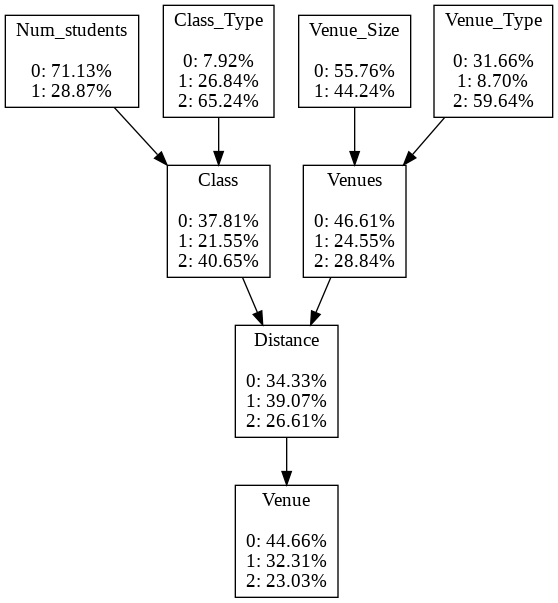

In [105]:
G = pgv.AGraph(directed=True)
inference = VariableElimination(baseline_model)

for element in digraph:

    probability_0 = inference.query([element[0]], show_progress=False)
    probability_1 = inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))

# Sampling

## Foward Sampling

In [106]:
def foward_sample(model, size=int(1e3)):

	inference = BayesianModelSampling(model)
	data = inference.forward_sample(size)
	data = data.sample(frac=1).reset_index(drop=True)

	return data

test_data = foward_sample(baseline_model)

  0%|          | 0/8 [00:00<?, ?it/s]

## Gibbs Sampling
- each random variable is iteratively resampled from its conditional distribution given the remaining

In [107]:
def gibbs_sample(model, size=int(1e3)):
	inference = GibbsSampling(model)
	data = inference.sample(size).reset_index(drop=True)
	return data

## Store data in csv

In [108]:
test_data.to_csv('./drive/MyDrive/RESEARCH/venue_allocation/data/test_data '+ '.csv')

# Structure Learning

## Score Based Structure Learning
- this approach construes model selection as an optimization task
- Has two building blocks:
	- 1. A scoring function $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$
	- 2. A search strategy to traverse the search space of possible models $M$ and select a model with optimal score.
- Commonly used scores to measure the fit between model and data are :
	- Bayesian Dirichlet scores such as BDeu or K2 
	- Bayesian Information Criterion (BIC, also called MDL)
- 

### Learn the model structure using Hill-Climb Search with K2score

  0%|          | 0/10000 [00:00<?, ?it/s]

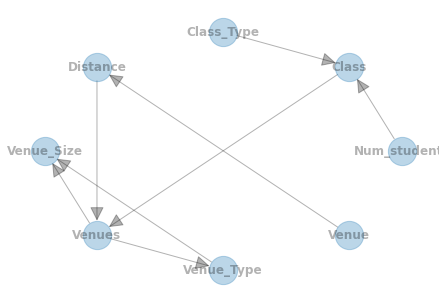

In [109]:
scoring_method = K2Score(data=test_data)
est = HillClimbSearch(data=test_data)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
)

nx.draw_circular(
    estimated_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

### Learn the model structure using Hill-Climb Search with BIC Score

  0%|          | 0/10000 [00:00<?, ?it/s]

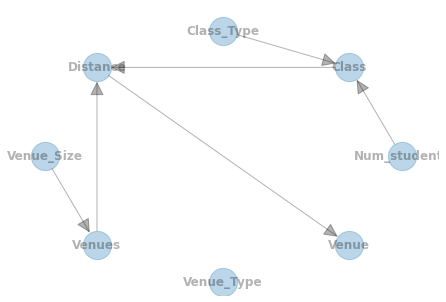

In [110]:
scoring_method1 = BicScore(data=test_data)
bic_est = HillClimbSearch(data=test_data)
bic_model = bic_est.estimate(
    scoring_method=scoring_method1, max_indegree=4, max_iter=int(1e4)
)

nx.draw_circular(
    bic_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

## Hybrid Structure Learning
The MMHC algorithm combines the constraint-based and score-based method. It has two parts:

- 1.Learn undirected graph skeleton using the constraint-based construction procedure MMPC

- 2.Orient edges using score-based optimization (BDeu score + modified hill-climbing)

Downside :
- takes longer to generate a structure 

Part 1) Skeleton:  [('Num_students', 'Class'), ('Num_students', 'Distance'), ('Num_students', 'Venues'), ('Num_students', 'Class_Type'), ('Class', 'Venue_Size'), ('Class', 'Venue_Type'), ('Distance', 'Venues'), ('Distance', 'Venue_Type'), ('Distance', 'Venue_Size'), ('Venue_Size', 'Venue'), ('Venues', 'Venue')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('Class', 'Num_students'), ('Class_Type', 'Num_students'), ('Venues', 'Distance')]


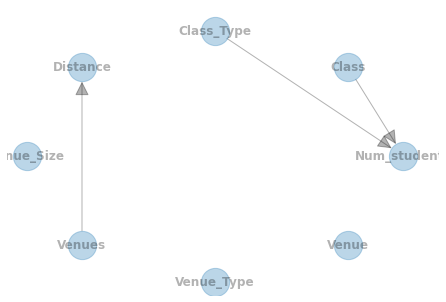

In [111]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

mmhc = MmhcEstimator(test_data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(test_data)
Mmhc_model = hc.estimate(scoring_method=BDeuScore(test_data), white_list=skeleton.to_directed().edges())
print("Part 2) Model:    ", Mmhc_model.edges())
nx.draw_circular(
    Mmhc_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()

# Parameter Learning

### Maximum Likelihood Estimation
- estimates the conditional probability tables (CPTs) for the variables of a Bayesian Network, given some data set.

#### STEPS
- use the relative frequencies, with which the variable states have occured.
- we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal.

#### KEY :
- >  mle.estimate_cpd(variable) computes the state counts and divides each cell by the (conditional) sample size. 
- >  mle.get_parameters() returns a list of CPDs for all variable of the model.

#### Problems with MLE :
- overfits data
- If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.
- When estimating parameters for Bayesian networks, lack of data is a frequent problem.
- Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation
- If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for 10^3 = 1000 parents configurations. 
- This makes MLE very fragile and unstable for learning Bayesian Network parameters. 
- A way to mitigate MLE's overfitting is Bayesian Parameter Estimation.

#### MLE for Hill-Climb Search with K2score

In [112]:
# Defining the Bayesian Model structure, copy k2 model
mle_k2_model = BayesianNetwork(estimated_model)
mle_k2_model.fit(test_data, estimator=MaximumLikelihoodEstimator)

for cpd in mle_k2_model.get_cpds():
	print(cpd)

+-----------------+-------+
| Num_students(0) | 0.725 |
+-----------------+-------+
| Num_students(1) | 0.275 |
+-----------------+-------+
+--------------+--------------------+-----+----------------------+
| Class_Type   | Class_Type(0)      | ... | Class_Type(2)        |
+--------------+--------------------+-----+----------------------+
| Num_students | Num_students(0)    | ... | Num_students(1)      |
+--------------+--------------------+-----+----------------------+
| Class(0)     | 0.1694915254237288 | ... | 0.7989130434782609   |
+--------------+--------------------+-----+----------------------+
| Class(1)     | 0.0                | ... | 0.14130434782608695  |
+--------------+--------------------+-----+----------------------+
| Class(2)     | 0.8305084745762712 | ... | 0.059782608695652176 |
+--------------+--------------------+-----+----------------------+
+---------------+-------+
| Class_Type(0) | 0.077 |
+---------------+-------+
| Class_Type(1) | 0.266 |
+---------------+--

#### MLE for Hill-Climb Search with BIC score

In [113]:
# Defining the Bayesian Model structure, copy bic model
mle_bic_model = BayesianNetwork(bic_model)
mle_bic_model.fit(test_data, estimator=MaximumLikelihoodEstimator)

for cpd in mle_bic_model.get_cpds():
	print(cpd)

+-----------------+-------+
| Num_students(0) | 0.725 |
+-----------------+-------+
| Num_students(1) | 0.275 |
+-----------------+-------+
+--------------+--------------------+-----+----------------------+
| Class_Type   | Class_Type(0)      | ... | Class_Type(2)        |
+--------------+--------------------+-----+----------------------+
| Num_students | Num_students(0)    | ... | Num_students(1)      |
+--------------+--------------------+-----+----------------------+
| Class(0)     | 0.1694915254237288 | ... | 0.7989130434782609   |
+--------------+--------------------+-----+----------------------+
| Class(1)     | 0.0                | ... | 0.14130434782608695  |
+--------------+--------------------+-----+----------------------+
| Class(2)     | 0.8305084745762712 | ... | 0.059782608695652176 |
+--------------+--------------------+-----+----------------------+
+---------------+-------+
| Class_Type(0) | 0.077 |
+---------------+-------+
| Class_Type(1) | 0.266 |
+---------------+--

#### MLE for Hybrid Structure learning

In [114]:
# Defining the Bayesian Model structure, copy Mmhc model
mle_mmhc_model = BayesianNetwork(Mmhc_model)
mle_mmhc_model.fit(test_data, estimator=MaximumLikelihoodEstimator)

for cpd in mle_mmhc_model.get_cpds():
	print(cpd)

+-----------------+-----+---------------------+
| Class           | ... | Class(2)            |
+-----------------+-----+---------------------+
| Class_Type      | ... | Class_Type(2)       |
+-----------------+-----+---------------------+
| Num_students(0) | ... | 0.9618055555555556  |
+-----------------+-----+---------------------+
| Num_students(1) | ... | 0.03819444444444445 |
+-----------------+-----+---------------------+
+----------+-------+
| Class(0) | 0.379 |
+----------+-------+
| Class(1) | 0.199 |
+----------+-------+
| Class(2) | 0.422 |
+----------+-------+
+---------------+-------+
| Class_Type(0) | 0.077 |
+---------------+-------+
| Class_Type(1) | 0.266 |
+---------------+-------+
| Class_Type(2) | 0.657 |
+---------------+-------+
+-------------+---------------------+-----+---------------------+
| Venues      | Venues(0)           | ... | Venues(2)           |
+-------------+---------------------+-----+---------------------+
| Distance(0) | 0.49134199134199136 | ...

### Bayesian Parameter Estimation
- starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed.
- Those "priors" are then updated, using the state counts from the observed data
- One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. 
- Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable

#### Priors
- K2 prior - simply adds 1 to the count of every single state.
- BDeu (Bayesian Dirichlet equivalent uniform) prior - is a somewhat more sensible choice of prior. 
	- For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration)

##### K2 prior

In [115]:
# Defining the Bayesian Model structure, copy baseline
bpe_model =  baseline_model.copy()

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_model.fit(test_data, estimator=BayesianEstimator, prior_type="k2")
for cpd in bpe_model.get_cpds():
	print(cpd)

+---------------+-----------+
| Class_Type(0) | 0.0777667 |
+---------------+-----------+
| Class_Type(1) | 0.266201  |
+---------------+-----------+
| Class_Type(2) | 0.656032  |
+---------------+-----------+
+-----------------+----------+
| Num_students(0) | 0.724551 |
+-----------------+----------+
| Num_students(1) | 0.275449 |
+-----------------+----------+
+---------------+-----------+
| Venue_Type(0) | 0.301097  |
+---------------+-----------+
| Venue_Type(1) | 0.0967099 |
+---------------+-----------+
| Venue_Type(2) | 0.602193  |
+---------------+-----------+
+---------------+----------+
| Venue_Size(0) | 0.562874 |
+---------------+----------+
| Venue_Size(1) | 0.437126 |
+---------------+----------+
+--------------+-----+---------------------+
| Class_Type   | ... | Class_Type(2)       |
+--------------+-----+---------------------+
| Num_students | ... | Num_students(1)     |
+--------------+-----+---------------------+
| Class(0)     | ... | 0.7914438502673797  |
+---------

##### K2 prior for Hill-Climb Search with K2score

In [116]:
# Defining the Bayesian Model structure, copy k2 score 
bpe_k2_model =  BayesianNetwork(estimated_model)


# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_k2_model.fit(test_data, estimator=BayesianEstimator, prior_type="k2")
for cpd in bpe_k2_model.get_cpds():
	print(cpd)

+-----------------+----------+
| Num_students(0) | 0.724551 |
+-----------------+----------+
| Num_students(1) | 0.275449 |
+-----------------+----------+
+--------------+-----+---------------------+
| Class_Type   | ... | Class_Type(2)       |
+--------------+-----+---------------------+
| Num_students | ... | Num_students(1)     |
+--------------+-----+---------------------+
| Class(0)     | ... | 0.7914438502673797  |
+--------------+-----+---------------------+
| Class(1)     | ... | 0.1443850267379679  |
+--------------+-----+---------------------+
| Class(2)     | ... | 0.06417112299465241 |
+--------------+-----+---------------------+
+---------------+-----------+
| Class_Type(0) | 0.0777667 |
+---------------+-----------+
| Class_Type(1) | 0.266201  |
+---------------+-----------+
| Class_Type(2) | 0.656032  |
+---------------+-----------+
+-------------+--------------------+---------------------+---------------------+
| Venue       | Venue(0)           | Venue(1)            | 

##### K2 prior for Hill-Climb Search with BIC score

In [117]:
# Defining the Bayesian Model structure, copy bic
bpe_bic_model =  BayesianNetwork(bic_model)

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_bic_model.fit(test_data, estimator=BayesianEstimator, prior_type="k2")
for cpd in bpe_bic_model.get_cpds():
	print(cpd)

+-----------------+----------+
| Num_students(0) | 0.724551 |
+-----------------+----------+
| Num_students(1) | 0.275449 |
+-----------------+----------+
+--------------+-----+---------------------+
| Class_Type   | ... | Class_Type(2)       |
+--------------+-----+---------------------+
| Num_students | ... | Num_students(1)     |
+--------------+-----+---------------------+
| Class(0)     | ... | 0.7914438502673797  |
+--------------+-----+---------------------+
| Class(1)     | ... | 0.1443850267379679  |
+--------------+-----+---------------------+
| Class(2)     | ... | 0.06417112299465241 |
+--------------+-----+---------------------+
+---------------+-----------+
| Class_Type(0) | 0.0777667 |
+---------------+-----------+
| Class_Type(1) | 0.266201  |
+---------------+-----------+
| Class_Type(2) | 0.656032  |
+---------------+-----------+
+-------------+---------------------+-----+---------------------+
| Class       | Class(0)            | ... | Class(2)            |
+-------

##### K2 prior for Hybrid Structure learning

In [118]:
# Defining the Bayesian Model structure, Mmhc baseline
bpe_mmhc_model =  BayesianNetwork(Mmhc_model)

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bpe_mmhc_model.fit(test_data, estimator=BayesianEstimator, prior_type="k2")
for cpd in bpe_mmhc_model.get_cpds():
	print(cpd)

+-----------------+-----+----------------------+
| Class           | ... | Class(2)             |
+-----------------+-----+----------------------+
| Class_Type      | ... | Class_Type(2)        |
+-----------------+-----+----------------------+
| Num_students(0) | ... | 0.9586206896551724   |
+-----------------+-----+----------------------+
| Num_students(1) | ... | 0.041379310344827586 |
+-----------------+-----+----------------------+
+----------+----------+
| Class(0) | 0.378863 |
+----------+----------+
| Class(1) | 0.199402 |
+----------+----------+
| Class(2) | 0.421735 |
+----------+----------+
+---------------+-----------+
| Class_Type(0) | 0.0777667 |
+---------------+-----------+
| Class_Type(1) | 0.266201  |
+---------------+-----------+
| Class_Type(2) | 0.656032  |
+---------------+-----------+
+-------------+---------------------+-----------+---------------------+
| Venues      | Venues(0)           | Venues(1) | Venues(2)           |
+-------------+---------------------+

##### BDeu prior

In [119]:
# Defining the Bayesian Model structure, copy baseline
bdeu_model =  baseline_model.copy()

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bdeu_model.fit(test_data, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in bdeu_model.get_cpds():
	print(cpd)

+---------------+-----------+
| Class_Type(0) | 0.0782753 |
+---------------+-----------+
| Class_Type(1) | 0.266335  |
+---------------+-----------+
| Class_Type(2) | 0.65539   |
+---------------+-----------+
+-----------------+----------+
| Num_students(0) | 0.723881 |
+-----------------+----------+
| Num_students(1) | 0.276119 |
+-----------------+----------+
+---------------+-----------+
| Venue_Type(0) | 0.301161  |
+---------------+-----------+
| Venue_Type(1) | 0.0971808 |
+---------------+-----------+
| Venue_Type(2) | 0.601658  |
+---------------+-----------+
+---------------+----------+
| Venue_Size(0) | 0.562687 |
+---------------+----------+
| Venue_Size(1) | 0.437313 |
+---------------+----------+
+--------------+-----+----------------------+
| Class_Type   | ... | Class_Type(2)        |
+--------------+-----+----------------------+
| Num_students | ... | Num_students(1)      |
+--------------+-----+----------------------+
| Class(0)     | ... | 0.7968139464983469   |
+---

##### BDeu prior for Hill-Climb Search with K2score

In [120]:
# Defining the Bayesian Model structure, copy baseline
bdeu_k2_model =  BayesianNetwork(estimated_model)

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bdeu_k2_model.fit(test_data, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in bdeu_k2_model.get_cpds():
	print(cpd)

+-----------------+----------+
| Num_students(0) | 0.723881 |
+-----------------+----------+
| Num_students(1) | 0.276119 |
+-----------------+----------+
+--------------+-----+----------------------+
| Class_Type   | ... | Class_Type(2)        |
+--------------+-----+----------------------+
| Num_students | ... | Num_students(1)      |
+--------------+-----+----------------------+
| Class(0)     | ... | 0.7968139464983469   |
+--------------+-----+----------------------+
| Class(1)     | ... | 0.1421701232341449   |
+--------------+-----+----------------------+
| Class(2)     | ... | 0.061015930267508275 |
+--------------+-----+----------------------+
+---------------+-----------+
| Class_Type(0) | 0.0782753 |
+---------------+-----------+
| Class_Type(1) | 0.266335  |
+---------------+-----------+
| Class_Type(2) | 0.65539   |
+---------------+-----------+
+-------------+---------------------+-----+----------------------+
| Venue       | Venue(0)            | ... | Venue(2)          

##### BDeu prior for Hill-Climb Search with BIC score

In [121]:
# Defining the Bayesian Model structure, copy baseline
bdeu_bic_model =  BayesianNetwork(bic_model)

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bdeu_bic_model.fit(test_data, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in bdeu_bic_model.get_cpds():
	print(cpd)

+-----------------+----------+
| Num_students(0) | 0.723881 |
+-----------------+----------+
| Num_students(1) | 0.276119 |
+-----------------+----------+
+--------------+-----+----------------------+
| Class_Type   | ... | Class_Type(2)        |
+--------------+-----+----------------------+
| Num_students | ... | Num_students(1)      |
+--------------+-----+----------------------+
| Class(0)     | ... | 0.7968139464983469   |
+--------------+-----+----------------------+
| Class(1)     | ... | 0.1421701232341449   |
+--------------+-----+----------------------+
| Class(2)     | ... | 0.061015930267508275 |
+--------------+-----+----------------------+
+---------------+-----------+
| Class_Type(0) | 0.0782753 |
+---------------+-----------+
| Class_Type(1) | 0.266335  |
+---------------+-----------+
| Class_Type(2) | 0.65539   |
+---------------+-----------+
+-------------+---------------------+-----+---------------------+
| Class       | Class(0)            | ... | Class(2)           

##### BDeu prior for Hybrid Structure learning

In [122]:
# Defining the Bayesian Model structure, copy baseline
bdeu_mmhc_model =  BayesianNetwork(Mmhc_model)

# adjust all CPDs of `model` using MLE, estimates cpds inplace
bdeu_mmhc_model.fit(test_data, estimator=BayesianEstimator, prior_type="BDeu")
for cpd in bdeu_mmhc_model.get_cpds():
	print(cpd)

+-----------------+-----+---------------------+
| Class           | ... | Class(2)            |
+-----------------+-----+---------------------+
| Class_Type      | ... | Class_Type(2)       |
+-----------------+-----+---------------------+
| Num_students(0) | ... | 0.9609164420485176  |
+-----------------+-----+---------------------+
| Num_students(1) | ... | 0.03908355795148248 |
+-----------------+-----+---------------------+
+----------+----------+
| Class(0) | 0.378773 |
+----------+----------+
| Class(1) | 0.199668 |
+----------+----------+
| Class(2) | 0.421559 |
+----------+----------+
+---------------+-----------+
| Class_Type(0) | 0.0782753 |
+---------------+-----------+
| Class_Type(1) | 0.266335  |
+---------------+-----------+
| Class_Type(2) | 0.65539   |
+---------------+-----------+
+-------------+--------------------+---------------------+---------------------+
| Venues      | Venues(0)          | Venues(1)           | Venues(2)           |
+-------------+-------------

# Evaluation

### Correlation Score
- Function to score how well the model structure represents the correlations in the data.
- The model doesn’t need to be parameterized for this scor

In [123]:
from pgmpy.metrics import correlation_score
# baseline score
print('*'*5, "CORRELATION SCORES", '*'*5)
print()
print('*'*5, "Baseline model", '*'*5)
print(correlation_score(baseline_model, test_data, test="chi_square", significance_level=0.05), "\n")

print('*'*5, "Hill Climb Correllation scores", '*'*5)
print('-'*5, "K2 score MLE model", '-'*5)
print(correlation_score(mle_k2_model, test_data, test="chi_square", significance_level=0.05))
print('-'*5, "K2 score k2 prior model", '-'*5)
print(correlation_score(bpe_k2_model, test_data, test="chi_square", significance_level=0.05))

print('-'*5, "Bic score MLE model",'-'*5)
print(correlation_score(mle_bic_model, test_data, test="chi_square", significance_level=0.05))
print('-'*5, "Bic score k2 prior model",'-'*5)
print(correlation_score(mle_bic_model, test_data, test="chi_square", significance_level=0.05))
print('-'*5, "Bic score Bdeu prior model",'-'*5)
print(correlation_score(bdeu_bic_model, test_data, test="chi_square", significance_level=0.05), "\n")

print('*'*5, "Hybrid Structure MLE Learning scores", '*'*5)
print('-'*5, "Mmhc score MLE model",'-'*5)
print(correlation_score(mle_mmhc_model, test_data, test="chi_square", significance_level=0.05))
print('-'*5, "Mmhc score Bdeu prior model",'-'*5)
print(correlation_score(bdeu_mmhc_model, test_data, test="chi_square", significance_level=0.05))


***** CORRELATION SCORES *****

***** Baseline model *****
0.5714285714285714 

***** Hill Climb Correllation scores *****
----- K2 score MLE model -----
0.4166666666666667
----- K2 score k2 prior model -----
0.4166666666666667
----- Bic score MLE model -----
0.6451612903225806
----- Bic score k2 prior model -----
0.6451612903225806
----- Bic score Bdeu prior model -----
0.6451612903225806 

***** Hybrid Structure MLE Learning scores *****
----- Mmhc score MLE model -----
0.7619047619047621
----- Mmhc score Bdeu prior model -----
0.7619047619047621


### log-likelihood score
- Computes the log-likelihood of a given dataset i.e. $P(data | model)$.
- can be used to check how well the specified model describes the data. 
- This method requires the parameters of the model to be specified as well. 
- Direct interpretation of this score is difficult but can be used to compare the fit of two or more models. 
- A higher score means ab better fit

In [124]:
from pgmpy.metrics import log_likelihood_score

print('*'*5, "LOG-LIKELIHOOD SCORE", '*'*5)
print('*'*5, "Baseline model", '*'*5)
print(log_likelihood_score(baseline_model, test_data), "\n")

print('*'*5, "Hill Climb Search scores", '*'*5)
print('-'*5, "K2 score MLE model", '-'*5)
print(log_likelihood_score(mle_k2_model, test_data))
print('-'*5, "K2 score k2 prior model", '-'*5)
print(log_likelihood_score(bpe_k2_model, test_data))

print('-'*5, "Bic score MLE model",'-'*5)
print(log_likelihood_score(mle_bic_model, test_data))
print('-'*5, "Bic score k2 prior model",'-'*5)
print(log_likelihood_score(bpe_bic_model, test_data))
print('-'*5, "Bic score Bdeu prior model",'-'*5)
print(log_likelihood_score(bdeu_bic_model, test_data), "\n")

print('*'*5, "Hybrid Structure MLE Learning scores", '*'*5)
print('-'*5, "Mmhc score MLE model",'-'*5)
print(log_likelihood_score(mle_mmhc_model, test_data))
print('-'*5, "Mmhc score Bdeu prior model",'-'*5)
print(log_likelihood_score(bdeu_mmhc_model, test_data))



***** LOG-LIKELIHOOD SCORE *****
***** Baseline model *****
-6875.985903109137 

***** Hill Climb Search scores *****
----- K2 score MLE model -----
-6859.937600412194
----- K2 score k2 prior model -----
-6861.567161191635
----- Bic score MLE model -----
-6878.7359315524045
----- Bic score k2 prior model -----
-6880.0692067351565
----- Bic score Bdeu prior model -----
-6879.073142575166 

***** Hybrid Structure MLE Learning scores *****
----- Mmhc score MLE model -----
-7072.2345040982
----- Mmhc score Bdeu prior model -----
-7072.514216813635


# Visualize all probabilities for learned models

***** Hill Climb Search K2 Model *****


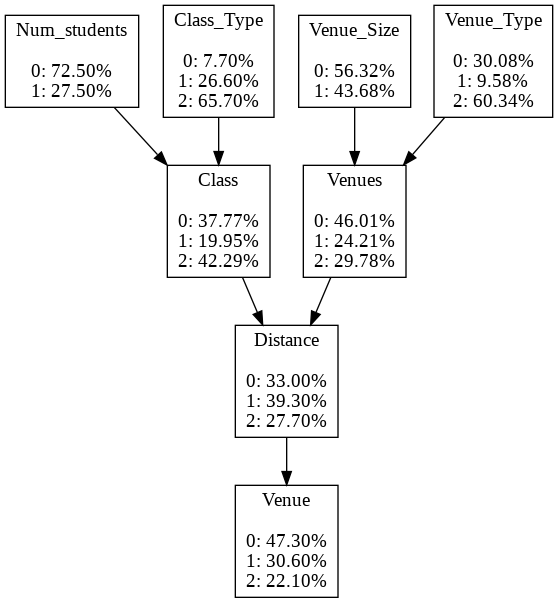

In [125]:
print('*'*5, "Hill Climb Search K2 Model", '*'*5)
G = pgv.AGraph(directed=True)
inference = VariableElimination(mle_k2_model)

for element in digraph:

    probability_0 = inference.query([element[0]], show_progress=False)
    probability_1 = inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))




***** Hill Climb Search Bic Model *****


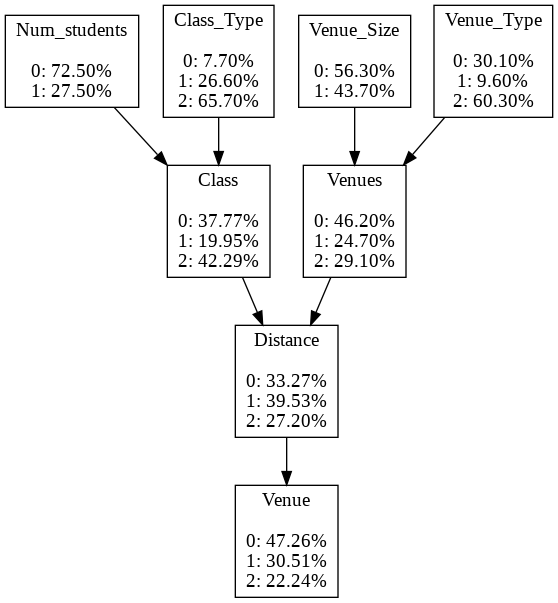

In [126]:
print('*'*5, "Hill Climb Search Bic Model", '*'*5)
G = pgv.AGraph(directed=True)
inference = VariableElimination(mle_bic_model)

for element in digraph:

    probability_0 = inference.query([element[0]], show_progress=False)
    probability_1 = inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))




***** Hybrid Structure Model *****


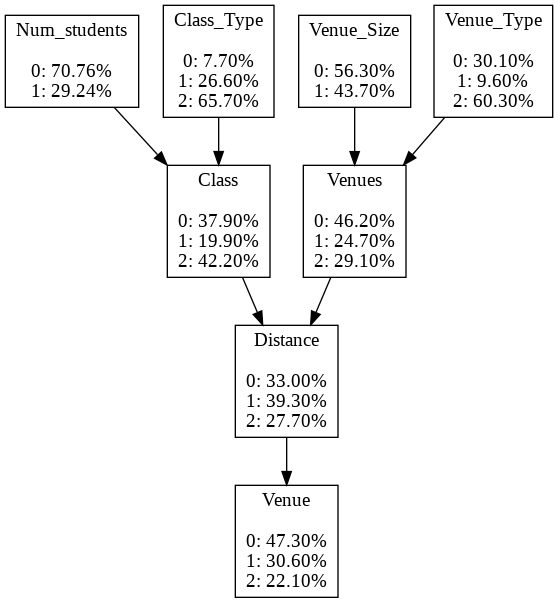

In [127]:
print('*'*5, "Hybrid Structure Model", '*'*5)
G = pgv.AGraph(directed=True)
inference = VariableElimination(mle_mmhc_model)

for element in digraph:

    probability_0 = inference.query([element[0]], show_progress=False)
    probability_1 = inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))

# Comparing scoring functions over k-runs

In [128]:
num_samples = [ 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
baseline = []
k2_model_score = []
bic_model_score = []

runs = 10
average_k2_model_score = []
average_bic_model_score = []

for i in num_samples:
  for ind in range(runs):
    # generate data
    temp_data = foward_sample(baseline_model, i)

    #  Structure Learning
    # Learn the model structure using Hill-Climb Search with K2score
    scoring_method = K2Score(data=temp_data)
    k2_est = HillClimbSearch(data=temp_data)
    k2_model = k2_est.estimate(
        scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
    )

    # Learn the model structure using Hill-Climb Search with BIC Score
    scoring_method1 = BicScore(data=temp_data)
    bic_est = HillClimbSearch(data=temp_data)
    bic_model = bic_est.estimate(
        scoring_method=scoring_method1, max_indegree=4, max_iter=int(1e4)
    )

    # Structure scores
    k2_model_score.append(structure_score(k2_model, temp_data, scoring_method="k2"))
    bic_model_score.append(structure_score(bic_model, temp_data, scoring_method="bic"))

  average_k2_model_score.append(np.mean(k2_model_score))
  average_bic_model_score.append(np.mean(bic_model_score))

print("Average K2 score : " , average_k2_model_score)
print("Average BIC score : " , average_bic_model_score)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Average K2 score :  [-142.94549789293262, -217.80596808172555, -288.5125742581118, -360.03991124551465, -434.4957332650886, -506.1747218418708, -576.7757236034058, -648.1491124534505, -720.1344793399363, -791.4812269404886]
Average BIC score :  [-154.7507107664082, -232.1279745974809, -304.0126928642743, -376.52221125503985, -451.7242723066808, -524.0096432613285, -595.6599472554535, -667.6510698088448, -740.5291943135132, -812.7833114998309]


# Comparing BIC with BPE model and Baseline model over k-runs

In [129]:
baseline_model_score = []
mle_bic_model_score = []
k2_bpe_bic_model_score = []
bdeu_bic_model_score = []
ave_baseline_model_score = []
ave_mle_bic_model_score = []
ave_k2_bpe_bic_model_score = []
ave_bdeu_bic_model_score = []

for i in num_samples:
  # generate data
  temp_data = foward_sample(baseline_model, i)
  for ind in range(runs):

    #  Structure Learning
    # Learn the model structure using Hill-Climb Search with BIC Score
    scoring_method1 = BicScore(data=temp_data)
    bic_est = HillClimbSearch(data=temp_data)
    bic_model = bic_est.estimate(
        scoring_method=scoring_method1, max_indegree=4, max_iter=int(1e4)
    )

    # Parameter learning
    # Bayesian Parameter Estimation
    # BDeu prior
    # Defining the Bayesian Model structure, copy baseline
    bdeu_bic_model =  BayesianNetwork(bic_model)
    bdeu_bic_model.fit(temp_data, estimator=BayesianEstimator, prior_type="BDeu")


    # Evaluation
    baseline_model_score.append(log_likelihood_score(baseline_model, temp_data))
    #  Hill Climb Search scores
    # Bic score Bdeu prior model
    bdeu_bic_model_score.append(log_likelihood_score(bdeu_bic_model, temp_data))
    # generate data
    temp_data = foward_sample(bdeu_bic_model, i)

  ave_baseline_model_score.append(np.mean(baseline_model_score))
  ave_bdeu_bic_model_score.append(np.mean(bdeu_bic_model_score))

print("Average Baseline model log-likelihood score ", ave_baseline_model_score)
print("Average BIC with BPE model log-likelihood score ", ave_baseline_model_score)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
  warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Average Baseline model log-likelihood score  [-171.37307676966444, -260.0722248176463, -348.37578615847275, -414.80834661492406, -487.39896912655, -561.8219637008267, -635.1641943248321, -707.4026430732777, -777.1484165042718, -849.1820364002471]
Average BIC with BPE model log-likelihood score  [-171.37307676966444, -260.0722248176463, -348.37578615847275, -414.80834661492406, -487.39896912655, -561.8219637008267, -635.1641943248321, -707.4026430732777, -777.1484165042718, -849.1820364002471]


# Removing random nodes from baseline model

***** Network with random nodes removed *****


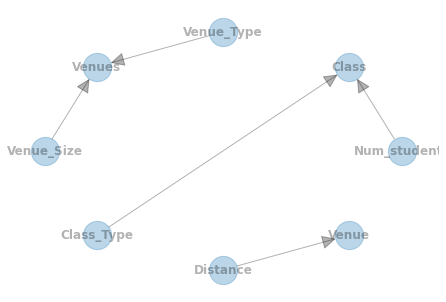

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -9.999999999998899e-05. Adjusting values.
  warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# sample random nodes from baseline
copy_baseline_model = baseline_model.copy()
random_digraph = random.sample(digraph, 5)
random_baseline_model = BayesianNetwork(random_digraph)

# plot network
print("*"*5, "Network with random nodes removed", "*"*5)
nx.draw_circular(
    random_baseline_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)
plt.show()


Variables = {"Num_students": 2,
        "Class_Type":3,
        "Class":3,
        "Venue_Size": 2,
        "Venue_Type": 3,
        "Venues": 3,
        "Distance": 3,
        "Venue": 3}



# Add cpds
for node in random_baseline_model.nodes:
  # get parents of node
  evidence = random_baseline_model.get_parents(node)
  # get evidence of parents
  Evidence_card = [Variables[i] for i in evidence]
  # add cpd
  random_baseline_model.add_cpds( TabularCPD( variable=node, variable_card=Variables[node],
                       values= cpd_values(variable_card=Variables[node], evidence_card=Evidence_card),
                       evidence=evidence, 
                       evidence_card=Evidence_card ) if len(Evidence_card)>0 else TabularCPD( variable=node, variable_card=Variables[node], values=cpd_values(variable_card=Variables[node])))

# sample data
random_data = foward_sample(random_baseline_model, 100)
# store data in csv
test_data.to_csv('./drive/MyDrive/RESEARCH/venue_allocation/data/random_data '+ '.csv')

# Structure learning
# Learn the model structure using Hill-Climb Search with BIC Score
scoring_method = BicScore(data=random_data)
random_est = HillClimbSearch(data=random_data)
random_baseline_model = random_est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
)

# Parameter learning
# Bayesian Parameter Estimation
# BDeu prior
# Defining the Bayesian Model structure, copy baseline
bdeu_random_baseline_model =  BayesianNetwork(random_baseline_model)
bdeu_random_baseline_model.fit(random_data, estimator=BayesianEstimator, prior_type="BDeu")

# save model to file
bdeu_random_baseline_model.save('./drive/MyDrive/RESEARCH/venue_allocation/models/bdeu_random_baseline_model.bif', filetype='bif')


# print conditional probabilities of nodes
print('*'*5, "Conditional probabilities random baseline model Model", '*'*5)

G = pgv.AGraph(directed=True)
random_baseline_model_inference = VariableElimination(bdeu_random_baseline_model)

for element in random_digraph:

    probability_0 = random_baseline_model_inference.query([element[0]], show_progress=False)
    probability_1 = random_baseline_model_inference.query([element[1]], show_progress=False)

    probability_0_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_0.values)]
    )
    probability_1_str = "\n".join(
        [f"{k}: {x * 100:.02f}%" for k, x in enumerate(probability_1.values)]
    )

    G.add_node(element[0], label=element[0] + "\n\n" + probability_0_str)
    G.add_node(element[1], label=element[1] + "\n\n" + probability_1_str)

    G.get_node(element[0]).attr["shape"] = "box"
    G.get_node(element[1]).attr["shape"] = "box"

    G.add_edge(element[0], element[1])

Image(G.draw(format="png", prog="dot"))





#Inference
Assuming all classes are in the science faculty
- what venue will be predicted when there are 45 students that need a Lecture room
>- Evidence provided 
>> - Num_students : 0 (number of students less or equal to 45)
>> - Class_Type: 2 (Type of class is lecture hall)
>- We expect the prediction to be a tut venue because the number of students is too small to occupy a Lecture hall.


<!-- venues = {'OLS1' : 2,
          'OLS2' : 2,
          'wss1' : 2,
          'wss2' : 2,
          'wss3' : 2,
          'fnb45': 2,
          'fnb47': 2,
          'fnb142': 2,
          'ogs1' : 2,
          'ogs2' : 2,
          'msl004': 1, 
          'msl005': 1,
          'msl0006':1,
          'shbb': 0,
          'sh01': 0,
          'rw4' : 0,
          'rw5' : 0,
          'rs41': 0,
          'rs246' : 0,
          'rs231' : 0,
          'rs128' : 0,
          'ogs3' : 0,
          'fnb150': 0,
          'fnb131': 0,
          'fnb115': 0,
          'bpl003': 0}

lecture_venue = ['OLS1','OLS2','wss1','wss2','wss3', 'fnb45','fnb47','fnb142','ogs1','ogs2']
lab_venue = ['msl004', 'msl005','msl0006']
tut_venue = ['shbb','sh01','rw4','rw5','rs41','rs246','rs231','rs128','ogs3','fnb150','fnb131','fnb115','bpl003'] -->

In [135]:
inference = VariableElimination(bdeu_bic_model)

pred = inference.map_query(['Venue', 'Venues'], evidence={'Num_students': 0, 'Class_Type': 2})
print(pred)
print("The predicted venue is a %s room "% ( "Tut" if pred['Venue']== 0 else "Lab" if pred['Venue']== 1 else "Lecture"))

# 0 tut, 1 Lab, 2 Lecture 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Venue': 0, 'Venues': 0}
The predicted venue is a Tut room 


- what venue will be predicted when there are 500 students that need a lecture hall
>- Evidence provided
>> - Num_students:1 (number of students is greater than 45)
>> - Class_Type:2 (Type of class is lecture hall)
>> - Venue_Size:2 (Type of venue is lecture hall)

In [136]:
pred = inference.map_query(['Venue'], evidence={'Num_students': 1, 'Class_Type': 2, 'Venue_Size': 1})
print(pred)

print("The predicted venue is a %s room"% ( "Tut" if pred['Venue']== 0 else "Lab" if pred['Venue']== 1 else "Lecture"))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Venue': 0}
The predicted venue is a Tut room


- If we have venues that accomodate less than 45 people, what to type of class would we assign the venue to

In [137]:
pred = inference.map_query(['Venue', 'Class_Type'], evidence={ 'Venue_Size': 0})
print(pred)

print("The predicted venue is a %s room "% ( "Tut" if pred['Venue']== 0 else "Lab" if pred['Venue']== 1 else "Lecture") + "and the class type will be %s"% ( "Tut" if pred['Class_Type']== 0 else "Lab" if pred['Class_Type']== 1 else "Lecture"))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Venue': 0, 'Class_Type': 2}
The predicted venue is a Tut room and the class type will be Lecture


# Inference after removing random nodes

- predict venue given random evidence

In [138]:
inference = VariableElimination(bdeu_random_baseline_model)

evidence_classes  = {
    "Num_students":{0 : " between 18 and 45",
                    1 : " greater than 45"},
    "Class_Type" : {0 : "a Tutorial",
                    1 : "a Lab",
                    2 : "a Lecture"},
    "Class" : {0 : "a Tutorial",
                    1 : "a Lab",
                    2 : "a Lecture"},
    "Venue_size":{0 : " 45 or less seats",
                  1 : "greater than 45 seats"},
    "Venue_Type":{0 : "a Tutorial",
                  1 : "a Lab",
                  2 : "a Lecture"},
    "Distance":{0: "Less than 50m from faculty office ",
                1 : "Between 50m and 100m from faculty office",
                2 : "Far from faculty office"},
    "Venues":{0 : "are Tutorial",
            1 : "are Lab",
            2 : "are Lecture" },
    "Venue":{0 : "a Tutorial",
            1 : "a Lab",
            2 : "a Lecture" }
}


# choose two random evidence
random_evidence = random.sample(bdeu_random_baseline_model.nodes, 2)

evidence = {}
for i in random_evidence:
  print(i, Variables[i])
  evidence.update({i : random.randint(0,Variables[i]-1)})

print(evidence)
# do a map query for, only when venue is not in the evidence
if 'Venue' not in random_evidence:
  pred = inference.map_query(['Venue'], evidence=evidence)


prediction = "The predicted venue is a %s room "% ( "Tut" if pred['Venue']== 0 else "Lab" if pred['Venue']== 1 else "Lecture") + "given evidence as : "

for i in random_evidence:
  prediction += i + " is "+ evidence_classes[i][evidence[i]] + ", " 

print(prediction)


Venue_Type 3
Distance 3
{'Venue_Type': 0, 'Distance': 0}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

The predicted venue is a Lecture room given evidence as : Venue_Type is a Tutorial, Distance is Less than 50m from faculty office , 
